In [1]:
import torch
import gc, os, warnings
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

# 전체 데이터셋 경로
DATA_PATH = './../2019MLJobFair/dataset'
os.listdir(DATA_PATH)

['faces_images',
 'sample_output_vision.csv',
 'test_vision.csv',
 'train_vision.csv']

In [2]:
# 이미지 폴더 경로
TRAIN_IMG_PATH = os.path.join(DATA_PATH, 'faces_images/')
os.listdir(TRAIN_IMG_PATH)

['face_0.png',
 'face_1.png',
 'face_10.png',
 'face_100.png',
 'face_1000.png',
 'face_1001.png',
 'face_1002.png',
 'face_1003.png',
 'face_1004.png',
 'face_1005.png',
 'face_1006.png',
 'face_1007.png',
 'face_1008.png',
 'face_1009.png',
 'face_101.png',
 'face_1010.png',
 'face_1011.png',
 'face_1012.png',
 'face_1013.png',
 'face_1014.png',
 'face_1015.png',
 'face_1016.png',
 'face_1017.png',
 'face_1018.png',
 'face_1019.png',
 'face_102.png',
 'face_1020.png',
 'face_1021.png',
 'face_1022.png',
 'face_1023.png',
 'face_1024.png',
 'face_1025.png',
 'face_1026.png',
 'face_1027.png',
 'face_1028.png',
 'face_1029.png',
 'face_103.png',
 'face_1030.png',
 'face_1031.png',
 'face_1032.png',
 'face_1033.png',
 'face_1034.png',
 'face_1035.png',
 'face_1036.png',
 'face_1037.png',
 'face_1038.png',
 'face_1039.png',
 'face_104.png',
 'face_1040.png',
 'face_1041.png',
 'face_1042.png',
 'face_1043.png',
 'face_1044.png',
 'face_1045.png',
 'face_1046.png',
 'face_1047.png',
 'fac

In [3]:
# CSV 파일 경로
df_train = pd.read_csv(os.path.join(DATA_PATH, 'train_vision.csv'))
df_test = pd.read_csv(os.path.join(DATA_PATH, 'test_vision.csv'))
df_sample_output = pd.read_csv(os.path.join(DATA_PATH, 'sample_output_vision.csv'))

In [4]:
df_train.head()

,filename,label
0,face_3267.png,1
1,face_587.png,4
2,face_6585.png,4
3,face_3094.png,4
4,face_1170.png,4


In [5]:
df_test.head()

,filename
0,face_2624.png
1,face_3385.png
2,face_5015.png
3,face_6715.png
4,face_6171.png


In [6]:
df_sample_output.head()

,prediction
0,0
1,1
2,0
3,1
4,0


In [7]:
# Data 갯수 확인
print("Number of Train Data : {}".format(df_train.shape[0]))
print("Number of Test Data : {}".format(df_test.shape[0]))

Number of Train Data : 5850
Number of Test Data : 2000


official) 5,850개의 사진 이미지가 훈련용으로 제공되며 분류 모델이 빌드된 후에는 이를 제출해야 하는 2,000개의 테스트 이미지에 적용하여 그 결과를 제출하면 된다.

### Class distribution 확인

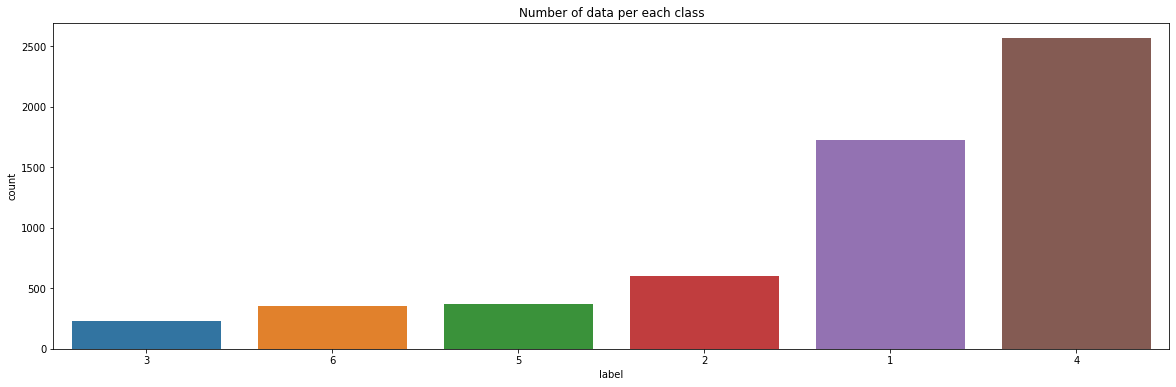

In [20]:
# grouped_df_train = df_train.sort_values(by="label", ascending=True).groupby('label')
# grouped_df_train.head()

plt.figure(figsize=(20, 6)) # class id가 겹쳐 출력되지 않게 고의로 가로 사이즈를 늘렸습니다.
sns.countplot(df_train["label"], order=df_train["label"].value_counts(ascending=True).index)
plt.title("Number of data per each class")
plt.show()

이 문제는 주어진 얼굴 이미지 (128x128)를 다음 여섯 가지의 카테고리로 분류해주는 것이다.

- <b>분류1: 안경쓰지 않은 남자 성인</b>
- 분류2: 안경쓴 남자 성인
- 분류3: 남자 아동
- <b>분류4: 안경쓰지 않은 여자 성인</b>
- 분류5: 안경쓴 여자 성인
- 분류6: 여자 아동

클래스 분포 확인 결과 Imbalance문제가 심각한 것을 확인하였고, 따라서 Cross validation을 수행하는 과정에서 stratified sampling을 수행해 어느 정도 클래스 불균형 문제를 해결할 필요가 있다.

In [22]:
cntEachClass = df_train["label"].value_counts(ascending=False)
print("Class with most count  : {}".format(cntEachClass.index[0]))
print("Most Count : {}".format(cntEachClass.max()))

print("Class with fewest count  : {}".format(cntEachClass.index[-1]))
print("Fewest Count : {}".format(cntEachClass.min()))

print("Mean  : {}".format(cntEachClass.mean()))

Class with most count  : 4
Most Count : 2568
Class with fewest count  : 3
Fewest Count : 230
Mean  : 975.0


안경을 쓰지 않은 남자 성인(4번 클래스)과 안경을 쓰지 않은 여자 성인(1번 클래스)이 가장 비중이 크고, 남자 아동, 여자 아동 등의 클래스는 비중이 대단히 적음을 확인할 수 있다. 